In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import re
from pandas.plotting import scatter_matrix
from sklearn.metrics import log_loss, f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from category_encoders import one_hot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [112]:
######################################################################################################################
#                                                                                                                    #
#                                            DATASET LOADING AND MERGING                                             #
#                                                                                                                    #
######################################################################################################################

In [113]:
# Helper function for merging supporting datasets to each of the main datasets (ebb_set1.csv, ebb_set2.csv and eval_set.csv) 
# consistently. Uses left outer join to preserve valuable samples from these datasets.
def merge_supporting_datasets(suffix):
    df = pd.read_csv(f"../../data/{suffix}")
    df.rename({"year": "phone_release_year"}, axis='columns', inplace=True)
    
    # Suspensions dataset
    suspensions_df = pd.read_csv(f"../../data/suspensions_{suffix}")
    suspensions_by_cust_id = suspensions_df["customer_id"].value_counts(sort=False).reset_index(level=0)
    suspensions_by_cust_id = suspensions_by_cust_id.rename(columns={'index': 'customer_id', 'customer_id': 'suspension_count_suspension_m'})
    merged_df = pd.merge(left=df, right=suspensions_by_cust_id, how="left", on="customer_id")
    
    # Activations dataset
    activations_df = pd.read_csv(f"../../data/activations_{suffix}")
    
    # Deactivations dataset
    deactivations_df = pd.read_csv(f"../../data/deactivations_{suffix}")
    deactivations_by_cust_id = deactivations_df["customer_id"].value_counts(sort=False).reset_index(level=0)
    deactivations_by_cust_id = deactivations_by_cust_id.rename(columns={'index':'customer_id', 'customer_id':'past_due_count_deactivations_m'})
    past_due_counts_by_cust_id = deactivations_df.drop(['deactivation_date'], axis=1).loc[deactivations_df['deactivation_reason'] == "PASTDUE"].value_counts(sort=False)
    past_due_counts_by_cust_id.reset_index(level=0).columns
    past_due_counts_by_cust_id = deactivations_by_cust_id.rename(columns={'0': 'past_due_count_deactivations_m'})
    merged_df = pd.merge(left=merged_df, right=past_due_counts_by_cust_id, how="left", on="customer_id")
    
    # Interactions dataset
    interactions_df = pd.read_csv(f"../../data/interactions_{suffix}").drop(['date', 'issue', 'disposition'], axis=1)
    ebb_call_count_by_cust_id = interactions_df.loc[interactions_df['reason'] == 'Emergency Broadband Benefit Call'].value_counts(sort=False).reset_index()
    ebb_call_count_by_cust_id['ebb_call_count_interactions_m'] = ebb_call_count_by_cust_id[0]
    ebb_call_count_by_cust_id = ebb_call_count_by_cust_id.drop(['reason', 0], axis=1)
    merged_df = pd.merge(left=merged_df, right=ebb_call_count_by_cust_id, how="left", on="customer_id")
    
    # Throttles dataset
    throttles_df = pd.read_csv(f"../../data/throttling_{suffix}")
    throttles_by_cust_id = throttles_df["customer_id"].value_counts(sort=False).reset_index(level=0)
    throttles_by_cust_id = throttles_by_cust_id.rename(columns={'index': 'customer_id', 'customer_id': 'throttle_count_throttle_m'})
    merged_df = pd.merge(left=merged_df, right=throttles_by_cust_id, how="left", on="customer_id")
    
    # Support dataset
    support_df = pd.read_csv(f"../../data/support_{suffix}")
    unstacked_support_df = support_df.groupby('customer_id')['case_type'].value_counts(sort=False).unstack().fillna(0)
    # Use only balance and upgrades as new features as other values are too sparse or unlikely
    bal_and_upgrades_by_cust_id = unstacked_support_df[['BALANCE', 'Phone Upgrade']].reset_index()
    bal_and_upgrades_by_cust_id.rename(columns={'BALANCE': 'balance_count_support_m', 'Phone Upgrade': 'phone_update_count_support_m'}, inplace=True)
    merged_df = pd.merge(left=merged_df, right=bal_and_upgrades_by_cust_id, how="left", on="customer_id")
    
    # Loyalty dataset
    loyalty_df = pd.read_csv(f"../../data/loyalty_program_{suffix}").drop(["date", "total_quantity"], axis=1)
    loyalty_df = loyalty_df.rename({'lrp_enrolled': 'lrp_enrolled_loyalty_m'}, axis=1)
    merged_df = pd.merge(left=merged_df, right=loyalty_df, how="left", on="customer_id")

    return merged_df

In [114]:
merged_ebb1_df = merge_supporting_datasets("ebb_set1.csv")
merged_ebb2_df = merge_supporting_datasets("ebb_set2.csv") 
merged_eval_df = merge_supporting_datasets("eval_set.csv")

In [115]:
# Combine both ebb datasets together to take advantage of a larger dataset for training
combined_ebb_df = pd.concat([merged_ebb1_df, merged_ebb2_df], ignore_index=True)

np.random.seed(123)
                
# Per Bekker and Davis paper, represent PU dataset as set of triplets (X, ebb_eligible, s) with X a vector of features.
# If the example is labeled s = 1, then it belongs to the positive class: Pr(y = 1|s = 1) = 1 and when the observation 
# is unlabeled s = 0, then it can belong to either class.
combined_ebb_df['s'] = combined_ebb_df['ebb_eligible']
combined_ebb_df['s'] = combined_ebb_df['s'].replace(np.nan, 0)

train_set, test_set = train_test_split(combined_ebb_df, test_size=0.2, random_state=123)

In [116]:
######################################################################################################################
#                                                                                                                    #
#                                                  DATA EXPLORATION                                                  #
#                                                                                                                    #
######################################################################################################################

In [117]:
df_exploration = train_set.copy() # To keep training set pristine make copy solely for data exploration

In [118]:
df_exploration.head()

,customer_id,last_redemption_date,first_activation_date,total_redemptions,tenure,number_upgrades,phone_release_year,manufacturer,operating_system,language_preference,...,marketing_comms_2,ebb_eligible,suspension_count_suspension_m,past_due_count_deactivations_m,ebb_call_count_interactions_m,throttle_count_throttle_m,balance_count_support_m,phone_update_count_support_m,lrp_enrolled_loyalty_m,s
37189,d800f63a9f0a405a7d7d05aff92800d52e840258,2022-03-25,2019-08-16,33,959,1,2017,Apple Inc,iOS,NaN,...,NaN,NaN,15.0,16.0,NaN,1.0,NaN,NaN,Y,0.0
80135,534ae65809f6724deb78db567de9db9b10c005f5,2020-04-20,2020-04-20,1,31,1,2019,SAMSUNG INC,ANDROID,NaN,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0
73466,08c117a283b6f7c2aa9aa24fc2c393dfb1db4c8a,2022-03-31,2020-09-24,23,330,2,2020,SAMSUNG INC,ANDROID,NaN,...,NaN,1.0,18.0,1.0,NaN,NaN,1.0,1.0,Y,1.0
34111,8df77e9000cb36c5c8a5ade6fe7c58e8cbc00657,2022-03-18,2018-04-14,44,1427,4,2021,SAMSUNG INC,ANDROID,NaN,...,48.0,NaN,48.0,36.0,NaN,NaN,0.0,2.0,NaN,0.0
81673,697ac72174d7949d5a7a8ea588efde767f932185,2020-04-20,2020-03-12,1,39,1,2019,SAMSUNG INC,ANDROID,NaN,...,NaN,NaN,25.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0


In [119]:
# For overview of feature data types involved
df_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78711 entries, 37189 to 15725
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     78711 non-null  object 
 1   last_redemption_date            78711 non-null  object 
 2   first_activation_date           78711 non-null  object 
 3   total_redemptions               78711 non-null  int64  
 4   tenure                          78711 non-null  int64  
 5   number_upgrades                 78711 non-null  int64  
 6   phone_release_year              78711 non-null  int64  
 7   manufacturer                    78061 non-null  object 
 8   operating_system                78061 non-null  object 
 9   language_preference             7480 non-null   object 
 10  opt_out_email                   4512 non-null   float64
 11  opt_out_loyalty_email           124 non-null    float64
 12  opt_out_loyalty_sms         

In [120]:
# Summary statistics for numerical features
df_exploration.iloc[:, :14].describe(include=np.number)

# Observation/s: 

# Based on the count results, looks safe to drop features opt_out_email, opt_out_loyalty_email, opt_out_loyalty_sms, 
# opt_out_mobiles_ads, opt_out_phone, marketing_comms_1, marketing_comms_2

,total_redemptions,tenure,number_upgrades,phone_release_year,opt_out_email,opt_out_loyalty_email,opt_out_loyalty_sms,opt_out_mobiles_ads
count,78711.000000,78711.000000,78711.000000,78711.000000,4512.0,124.0,140.0,39291.000000
mean,22.042599,680.753427,2.498279,2019.581393,1.0,1.0,1.0,0.901046
std,15.613475,573.723884,2.165511,10.030345,0.0,0.0,0.0,0.433729
min,1.000000,0.000000,1.000000,2009.000000,1.0,1.0,1.0,-1.000000
25%,9.000000,213.000000,1.000000,2017.000000,1.0,1.0,1.0,1.000000
50%,21.000000,522.000000,2.000000,2019.000000,1.0,1.0,1.0,1.000000
75%,33.000000,1058.000000,3.000000,2020.000000,1.0,1.0,1.0,1.000000
max,486.000000,4756.000000,55.000000,2099.000000,1.0,1.0,1.0,1.000000


In [121]:
df_exploration.iloc[:, 14:21].describe(include=np.number)

,opt_out_phone,total_revenues_bucket,marketing_comms_1,marketing_comms_2,ebb_eligible,suspension_count_suspension_m
count,6803.0,78711.000000,3075.000000,3066.000000,39423.0,74030.000000
mean,1.0,1.459173,1.476748,50.570124,1.0,15.770998
std,0.0,1.286485,0.748689,30.121166,0.0,16.350970
min,1.0,0.000000,1.000000,1.000000,1.0,1.000000
25%,1.0,0.000000,1.000000,29.000000,1.0,4.000000
50%,1.0,1.000000,1.000000,48.000000,1.0,10.000000
75%,1.0,2.000000,2.000000,66.000000,1.0,22.000000
max,1.0,5.000000,6.000000,343.000000,1.0,128.000000


In [122]:
df_exploration.iloc[:, 21:-1].describe(include=np.number)

,past_due_count_deactivations_m,ebb_call_count_interactions_m,throttle_count_throttle_m,balance_count_support_m,phone_update_count_support_m
count,73564.000000,10236.000000,27391.000000,52790.000000,52790.000000
mean,8.975939,3.623681,3.094411,0.629324,1.180602
std,8.190726,4.093800,3.482223,0.503160,1.681727
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,0.000000,0.000000
50%,6.000000,2.000000,2.000000,1.000000,1.000000
75%,13.000000,4.000000,4.000000,1.000000,1.000000
max,67.000000,48.000000,109.000000,3.000000,41.000000


In [123]:
# Summary statistics for string and object based features
df_exploration.iloc[:, 1:].describe(include=object)

,last_redemption_date,first_activation_date,manufacturer,operating_system,language_preference,state,lrp_enrolled_loyalty_m
count,78711,78711,78061,78061,7480,59535,38314
unique,972,3122,82,22,3,53,1
top,2022-03-23,2021-03-10,SAMSUNG INC,ANDROID,EN,FL,Y
freq,1824,124,22160,39382,7432,16978,38314


In [124]:
# Table showing missing data details for each feature.
missing_counts = df_exploration.isnull().sum().sort_values(ascending=False)
missing_percent = (df_exploration.isnull().sum()/df_exploration.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_counts, round(missing_percent * 100, 2)], axis=1, keys=['Missing Count', 'Missing Percent'])
missing_data

,Missing Count,Missing Percent
opt_out_loyalty_email,78587,99.84
opt_out_loyalty_sms,78571,99.82
marketing_comms_2,75645,96.10
marketing_comms_1,75636,96.09
opt_out_email,74199,94.27
opt_out_phone,71908,91.36
language_preference,71231,90.50
ebb_call_count_interactions_m,68475,87.00
throttle_count_throttle_m,51320,65.20
lrp_enrolled_loyalty_m,40397,51.32


<AxesSubplot:title={'center':'Missing data heat map by feature'}>

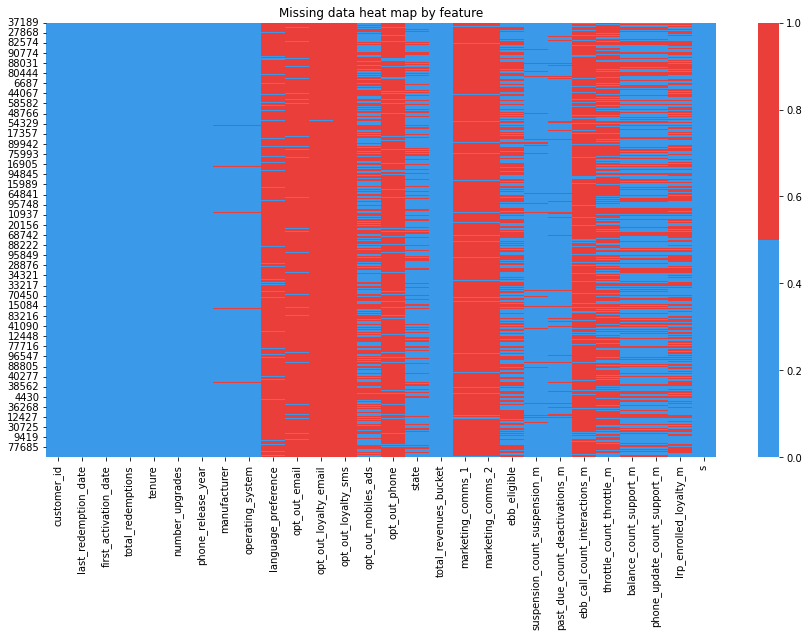

In [125]:
# Create missing data heat map
cols = df_exploration.columns # last 10 columns
colours = ['#3A99E9', '#E93E3A']

fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Missing data heat map by feature')
sns.heatmap(df_exploration[cols].isnull(), cmap=sns.color_palette(colours), ax=ax)

In [126]:
# Observation/s: raw form of last_redemption_date and first_activation_date are too granular and will lead to too many features
# More useful to transform to yy-mm or yy in preprocessing

df_exploration['first_activation_date'].value_counts().to_frame()

,first_activation_date
2021-03-10,124
2021-01-02,120
2021-01-05,120
2021-03-22,116
2020-12-28,114
...,...
2013-10-03,1
2014-07-17,1
2013-09-21,1
2014-06-27,1


In [127]:
df_exploration['last_redemption_date'].value_counts().to_frame()

,last_redemption_date
2022-03-23,1824
2022-03-16,1818
2022-03-22,1818
2022-03-21,1806
2022-03-17,1803
...,...
2018-08-18,1
2019-12-30,1
2018-12-19,1
2019-05-22,1


In [128]:
# Observation/s: language_preference not useful even if impute by filling with language EN, which would be a reasonable assumption
# given that Tracfone is US based. Only 22 ES values.
df_exploration['language_preference'].value_counts(dropna=False).to_frame()

,language_preference
NaN,71231
EN,7432
ES,43
ENG,5


<AxesSubplot:title={'center':'Feature correlations'}>

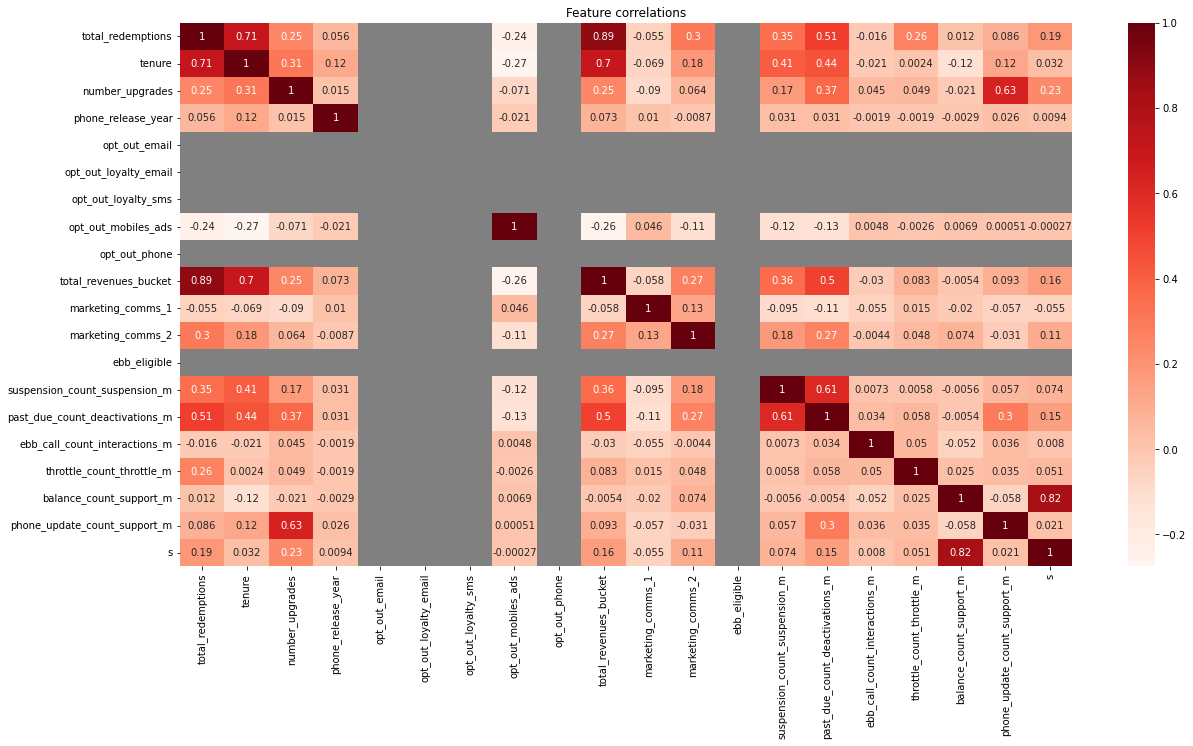

In [129]:
# Correlations visualization for numerical features
corr = df_exploration.corr()
colour = plt.cm.Reds.copy()
colour.set_bad('grey')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Feature correlations")
sns.heatmap(corr, annot=True, cmap=colour)

# Observation/s: total_redemptions, total_revenues_bucket and tenure show significant linear collinearity. 

In [130]:
df_exploration['total_revenues_bucket'].value_counts().to_frame()

,total_revenues_bucket
0,23623
1,19385
2,18630
3,10771
4,5615
5,687


In [131]:
df_exploration['tenure'].value_counts().to_frame()

,tenure
31,3626
0,615
61,495
62,354
1,271
...,...
2496,1
2757,1
2102,1
2450,1


In [132]:
df_exploration['total_redemptions'].value_counts().to_frame()

,total_redemptions
1,5278
2,2498
13,2048
9,2008
28,1950
...,...
144,1
127,1
132,1
125,1


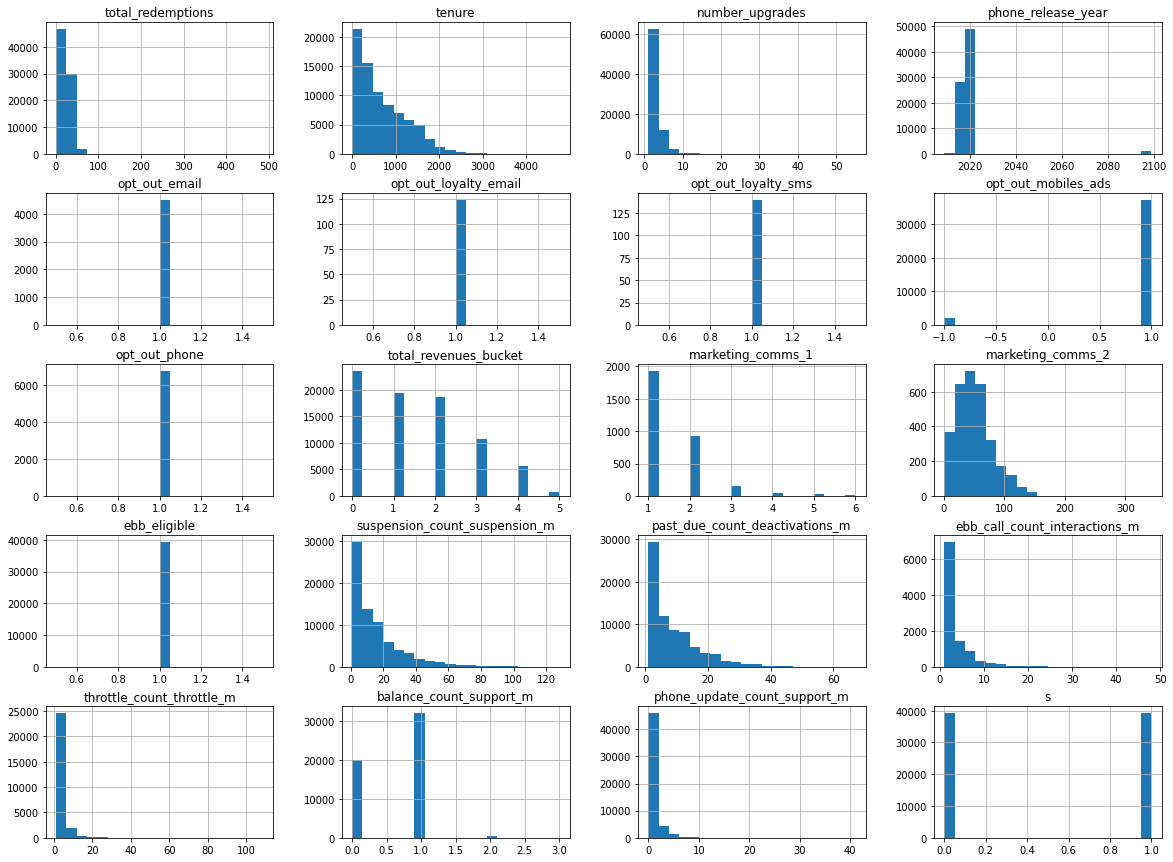

In [133]:
# Histograms for numerical features
df_exploration.hist(bins=20, figsize=(20,15))
plt.show()

# Observation/s: phone release year shows incorrect data (year 2099), will need to remove. 
# Most distributions highly skewed, consider use of median for imputation

Text(0.5, 0, 'Redemptions')

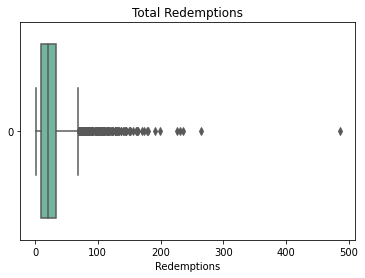

In [134]:
ax = sns.boxplot(data=df_exploration['total_redemptions'], orient="h", palette="Set2")
ax.set_title("Total Redemptions")
ax.set_xlabel("Redemptions")

Text(0.5, 0, 'Year')

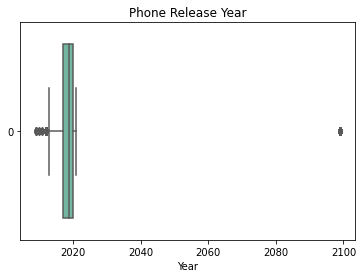

In [135]:
# Drill down into invalid data observed from histogram
ax = sns.boxplot(data=df_exploration['phone_release_year'], orient="h", palette="Set2")
ax.set_title("Phone Release Year")
ax.set_xlabel("Year")

In [136]:
# Observation/s: 1200 observations of year 2099 found in phone_release_year
df_exploration['phone_release_year'].astype(int).value_counts().sort_index(ascending=False).to_frame().reset_index().rename(columns={"index": "phone_release_year", "phone_release_year": "count"})

,phone_release_year,count
0,2099,1200
1,2021,7290
2,2020,18114
3,2019,13392
4,2018,10274
5,2017,18218
6,2016,5791
7,2015,3936
8,2014,136
9,2013,131


In [137]:
# Observation/s: Very inconsistent and messy naming of manufacturer feature values; e.g "SAMSUNG INC", "Samsung Korea", 
# "Samsung Electronics America". Clean this feature in pre-processing; could be a 
# useful feature since e.g Apple is premium vs Motorola, LG products
df_exploration["manufacturer"].value_counts().to_frame()

,manufacturer
SAMSUNG INC,22160
APPLE,18873
Apple Inc,11481
LG INC,8266
MOTOROLA INC,6785
...,...
"Motorola Mobility LLC, a Lenovo Company,Motorola Mobility LLC, a Lenovo Company,Motorola Mobility LLC, a Lenovo Company,Motorola Mobility LLC, a Lenovo Company",1
"Samsung Electronics America,Samsung Electronics America,Samsung Electronics America,Samsung Electronics America,Samsung Electronics America,Samsung Electronics America,Samsung Electronics America,Samsung Electronics America",1
Ruio Telecommunication Technologies Co Limited,1
"LG Electronics Inc.,LG Electronics Inc.,LG Electronics Inc.,LG Electronics Inc.",1


In [138]:
######################################################################################################################
#                                                                                                                    #
#                                                   DATA PREPROCESSING                                               #
#                                                                                                                    #
######################################################################################################################

In [139]:
df_X_train = train_set.drop("ebb_eligible", axis=1) 

In [140]:
# Drop features in data exploration found to be above a 60% missing threshold. 
# Not all features above this threshold are dropped; for example feature ebb_call_count_interactions_m was merged 
# from interactions dataset based on calls marked with reason EBB and may be more useful to keep.
def drop_sparse_features(df):
    df.drop(["language_preference", 
             "opt_out_email", 
             "opt_out_loyalty_email", 
             "opt_out_loyalty_sms", 
             "opt_out_phone", 
             "opt_out_mobiles_ads", 
             "marketing_comms_1", 
             "marketing_comms_2",
             "throttle_count_throttle_m"
            ], axis=1, inplace=True)
    return df

In [141]:
def drop_redundant_or_irrelevant_features(df):
    df.drop(["total_redemptions", # Drop total_redemptions due to 0.89 correlation with feature total_revenues_bucket
             "customer_id",
             "operating_system"
            ], axis=1, inplace=True)
    return df

In [142]:
# Clean manufacturer feature values using regex due to inconsistent naming e.g APPLE vs Apple Inc vs Apple US
def clean_manufacturer_names(df):
    # Convert to lower case    
    df['manufacturer'] = df["manufacturer"].str.lower()
    df['manufacturer'] = df['manufacturer'].replace(' ', '_', regex=True)
    manufacturers = ['samsung', 'apple', 'lg', 'motorola', 'alcatel', 'huawei', 'nokia']
    for m in manufacturers:
            df['manufacturer'] = df['manufacturer'].str.replace(r'(^.*' + re.escape(m) + '.*$)', f'{m}', regex=True)
    manufacturer_mask = df['manufacturer'].map(df_X_train['manufacturer'].value_counts()) < 50
    df['manufacturer'] =  df['manufacturer'].mask(manufacturer_mask, 'other')
    return df

In [143]:
# Replace invalid phone release year values with median. Median is used due to skewed distribution of this feature.
def clean_phone_release_year(df):
    df['phone_release_year'] = pd.to_datetime(df['phone_release_year'], format="%Y")
    date_after_condition = pd.Timestamp('2023-01-01')

    # Get median of valid phone release years (first filter out invalid values, including the 1200 observations of year 2099 in ebb_sets)
    phone_release_year_median = df[df['phone_release_year'] < date_after_condition]['phone_release_year'].dt.strftime('%Y').astype(int).median()

    df[df['phone_release_year'] > date_after_condition] = pd.Timestamp(str(int(phone_release_year_median)))
    df['phone_release_year'] = df['phone_release_year'].dt.strftime("%Y").astype('int32')
    return df

In [144]:
# Convert date features from overly granular per-day values to per-year
def transform_date_features(df):
    df['last_redemption_year'] = pd.to_datetime(df['last_redemption_date'], format='%Y-%m-%d').dt.year
    df['first_activation_year'] = pd.to_datetime(df['first_activation_date'], format='%Y-%m-%d').dt.year
    df.drop(["last_redemption_date", 
             "first_activation_date"], axis=1, inplace=True)
    return df

In [145]:
# Handle imputation for numerical features
def impute_missing_num(df):     
    # Imputed with 0 as opposed to a measure of central tendency due because these were merged features from supporting datasets. 
    # For example, a customer whom did not get suspended will not have a record of suspection in suspensions_ebb_set1.csv 
    # (meaning 0 suspensions instead of being actually missing).
    df['suspension_count_suspension_m'] = df['suspension_count_suspension_m'].fillna(0)
    df['ebb_call_count_interactions_m'] = df['ebb_call_count_interactions_m'].fillna(0)
    df['past_due_count_deactivations_m'] = df['past_due_count_deactivations_m'].fillna(0)
    df['balance_count_support_m'] = df['balance_count_support_m'].fillna(0)
    df['phone_update_count_support_m'] = df['phone_update_count_support_m'].fillna(0)
    
    # Impute for remaining numerical features
    numeric_columns = df.select_dtypes(include=['number']).columns
    for col in numeric_columns:
        avg = df[col].mean()
        df[col] = df[col].fillna(avg)
    return df

In [146]:
# For imputing missing values for categorical features. In general mode is used, as is commonly done for categorical data
def impute_missing_cat(df):
    df['state'] = df['state'].fillna(df['state'].mode().iloc[0])
    df['manufacturer'] = df['manufacturer'].fillna(df['manufacturer'].mode().iloc[0])
    
    # Impute with 'N' meaning not enrolled because such customers do not have enrolment per loyalty_program_ebb_set1.csv
    # and left outer join was used to merge into training features.     
    df['lrp_enrolled_loyalty_m'].fillna('N', inplace=True)
    
    # Impute for remaining categorical features 
    cat_columns = df.select_dtypes(include=['object']).columns
    for col in cat_columns:
        mode = df[col].mode()
        df[col] = df[col].fillna(mode)
    return df

In [147]:
# Normalize numerical features
def normalize_num_features(df):
    cols_num = [ 
        'tenure',
        'number_upgrades',
        'suspension_count_suspension_m',
        'past_due_count_deactivations_m',
        'ebb_call_count_interactions_m',
        'balance_count_support_m',
        'phone_update_count_support_m',
       ]
    features_num = df[cols_num]
         
    ct = ColumnTransformer([
        ('normalize', StandardScaler(), cols_num)
    ], remainder = 'passthrough')
    scaled_features_num = ct.fit_transform(features_num)
    
    # Reassign each (now scaled) feature to df
    df[cols_num] = pd.DataFrame(scaled_features_num, index=df.index, columns=cols_num)
    
    return df

In [148]:
# Use one hot encoding on appropriate categorical variables
def one_hot_encode_cat(df):
    cols_cat = [ 
            'phone_release_year', 
            'manufacturer',
            'state', 
            'total_revenues_bucket', 
            'lrp_enrolled_loyalty_m',
            'last_redemption_year',
            'first_activation_year'
           ]
    ohe = one_hot.OneHotEncoder(use_cat_names=True, cols=cols_cat)
    df = ohe.fit_transform(df)
    return df

In [149]:
# Combine all preprocessing steps into clean reusable pipeline
def apply_full_preprocessing_pipeline(df):
    return (
        df.
          pipe(drop_sparse_features).
          pipe(drop_redundant_or_irrelevant_features).
          pipe(clean_manufacturer_names).
          pipe(impute_missing_num).
          pipe(impute_missing_cat).
          pipe(transform_date_features).
          pipe(normalize_num_features).
          pipe(one_hot_encode_cat)
        )

In [150]:
# Apply full preprocessing pipeline onto train, test and eval datasets
df_X_train_preprocessed = apply_full_preprocessing_pipeline(df_X_train)
df_y_train = train_set["ebb_eligible"].copy()

df_X_test = test_set.drop("ebb_eligible", axis=1) 
df_X_test_preprocessed = apply_full_preprocessing_pipeline(df_X_test)
df_y_test = test_set["ebb_eligible"].copy()

df_X_eval = merged_eval_df.copy()
df_X_eval_preprocessed = apply_full_preprocessing_pipeline(df_X_eval)

df_X_train_preprocessed, df_X_test_preprocessed = df_X_train_preprocessed.align(df_X_test_preprocessed, join='inner', axis=1)  
df_X_test_preprocessed, df_X_eval_preprocessed = df_X_test_preprocessed.align(df_X_eval_preprocessed, join='inner', axis=1) 
df_X_test_preprocessed, df_X_train_preprocessed = df_X_test_preprocessed.align(df_X_train_preprocessed, join='inner', axis=1)  

In [151]:
######################################################################################################################
#                                                                                                                    #
#                                                MODEL A: Random Forest /w SCAR                                      #
#                                                                                                                    #
######################################################################################################################

In [158]:
# Apply SCAR assumption for ebb_eligible. 
df_y_train_random_forest = df_y_train.copy()
df_y_train_random_forest = df_y_train_random_forest.apply(lambda x: x if not np.isnan(x) else np.random.choice([0, 1])) 

df_y_test_random_forest = df_y_test.copy()
df_y_test_random_forest = df_y_test_random_forest.apply(lambda x: x if not np.isnan(x) else np.random.choice([0, 1]))

In [159]:
# # Identify most important features through execution of large Random Forest with 
# # max_features set to None, such that all features are considered for importance
rfc_feature_selection = RandomForestClassifier(n_estimators=300, max_features=None)
rfc_feature_selection.fit(df_X_train_preprocessed, df_y_train_random_forest)                   

RandomForestClassifier(max_features=None, n_estimators=300)

In [160]:
# Plot a histogram showing feature importances in descending order
feature_names = df_X_train_preprocessed.columns
feature_importances = list(zip(feature_names, rfc_feature_selection.feature_importances_))

top_k_features = 20
feature_importances.sort(key = lambda x : -x[1])
feature_importances_top_k = list(reversed(feature_importances[:top_k_features]))



<BarContainer object of 20 artists>

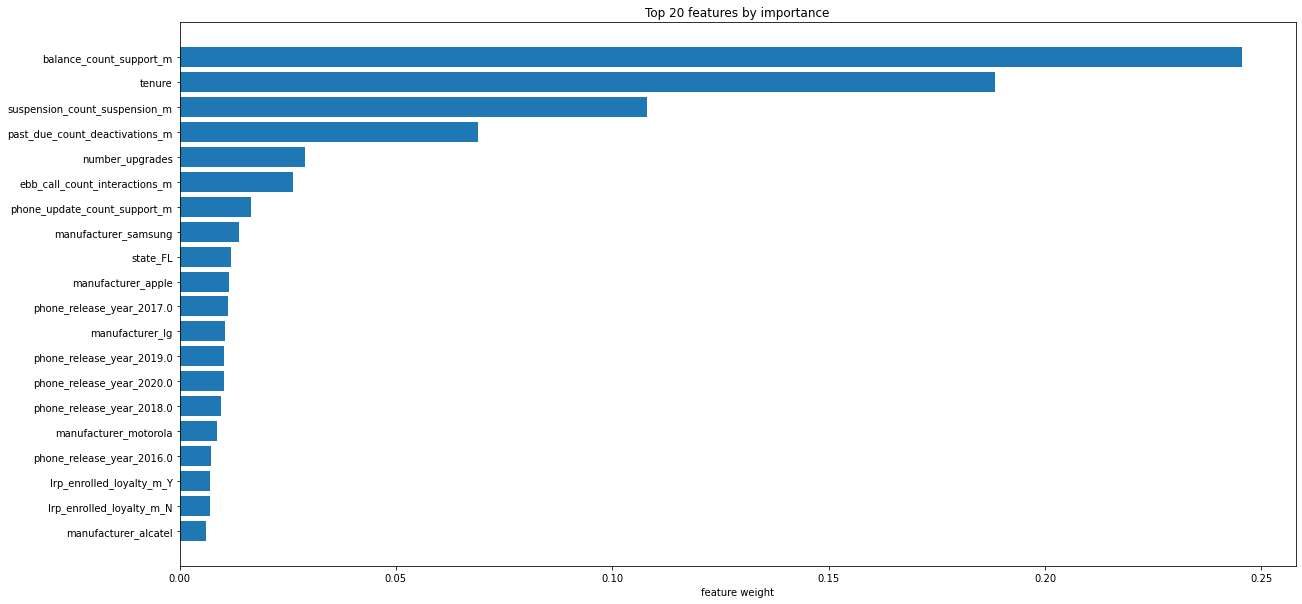

In [161]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title(f"Top {top_k_features} features by importance")
plt.xlabel("feature weight")
plt.barh([x[0] for x in feature_importances_top_k],[x[1] for x in feature_importances_top_k])

In [162]:
# Limit features to those passing importance threshold
threshold = 0.02
feature_by_threshold = list(filter(lambda x: x[1] >= threshold, feature_importances))[:10]
top_k_feature_names = list(list(zip(*feature_by_threshold))[0])
df_X_train_preprocessed_top_k_features = df_X_train_preprocessed.filter(top_k_feature_names)
df_X_test_preprocessed_top_k_features = df_X_test_preprocessed.filter(top_k_feature_names)
df_X_eval_preprocessed_top_k_features = df_X_eval_preprocessed.filter(top_k_feature_names)

In [163]:
# # Perform randomized cross-validation search for a set of hyperparameter permutations

# # Generate hyperparameters permutations for tuning via cross validation
hyperparameter_permutations = {
    # Number of trees used in Random Forest.
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
    # For all permutations use square root heuristic (per industry standard)
    'max_features': ['sqrt'], 
}

# # Use RandomizedSearchCV cross validation to find best value for hyperparamter n_estimators
# # (Side Note: We can say here that TracHack disallowed GridSearch because it was too computationally expensive for the shared server resources, 
# # so instead we will instead try a range of potentially effective permutations of hyperparameters through RandomizedSearchCV)
rfc = RandomForestClassifier()
rfc_randomized = RandomizedSearchCV(estimator = rfc, 
                                param_distributions = hyperparameter_permutations, 
                                n_iter = 5, 
                                cv=5, # Use 5-fold cross validation since computationally expensive
                                verbose=3, 
                                random_state=123)
rfc_randomized.fit(df_X_train_preprocessed_top_k_features, df_y_train_random_forest)

In [ ]:
print(f"Optimal hyperparameter values identified via cross validation: \n\n{rfc_randomized.best_estimator_}\n")

In [ ]:
# # Predict on the model with the optimal hyperparameters values found, for test set and eval set
df_y_test_pred = rfc_randomized.predict(df_X_test_preprocessed_top_k_features)
df_y_eval_pred = rfc_randomized.predict(df_X_eval_preprocessed_top_k_features)

In [ ]:
print(f"######### RANDOM FOREST RESULTS (TEST SET) ##########\n")
print(f"Accuracy score: {accuracy_score(df_y_test_random_forest, df_y_test_pred)}")
print(f"F1 Score: {f1_score(df_y_test_random_forest, df_y_test_pred)}")
print(f"Log Loss: {log_loss(df_y_test_random_forest, df_y_test_pred)}")
print(f"Classification Report:")
print(f"{classification_report(df_y_test_random_forest, df_y_test_pred)}")
print(f"#####################################################\n")

In [ ]:
# Step 6: Finally, make csv for overnight submission
df_submission = pd.DataFrame({
        'customer_id' : merged_eval_df['customer_id'], 
        'ebb_eligible': df_y_eval_pred
    })
df_submission.to_csv('../../submission/2022-04-17_model_A.csv', index=False)

In [ ]:
# Make supplementary submissions for different n_estimators hyperparamters

n_estimators = [100, 200, 300, 400, 500]
for n in n_estimators:
    rfc = RandomForestClassifier(n_estimators=n, max_features='sqrt')
    rfc_by_C = rfc.fit(df_X_train_preprocessed_top_k_features, df_y_train_random_forest)
    df_y_eval_pred = rfc_by_C.predict(df_X_eval_preprocessed_top_k_features)
    df_submission = pd.DataFrame({
        'customer_id' : merged_eval_df['customer_id'], 
        'ebb_eligible': df_y_eval_pred
    })
    print(f"Submitting random forest model with n_estimators = {n}")
    df_submission.to_csv(f"../../submission/2022-04-17_model_A_{n}.csv", index=False)

In [ ]:
######################################################################################################################
#                                                                                                                    #
#                MODEL B: Logistic Regression /w SCAR Assumption, Feature Selection, Hyperparameter Tuning           #
#                                                                                                                    #
######################################################################################################################

In [ ]:
# # Use SCAR assumption for ebb_eligible. 
df_y_train_log_reg = df_y_train.copy()
df_y_train_log_reg = df_y_train_log_reg.apply(lambda x: x if not np.isnan(x) else np.random.choice([0, 1])) 

df_y_test_log_reg = df_y_test.copy()
df_y_test_log_reg = df_y_test_log_reg.apply(lambda x: x if not np.isnan(x) else np.random.choice([0, 1]))

In [ ]:
# # Perform randomized cross-validation search for a set of hyperparameter permutations
                                              
# # Generate hyperparameters permutations for tuning via cross validation, focusing on penalty norm type and 
# # regularization strength
hyperparameter_permutations = {
    'C': [x for x in np.linspace(start = 0.25, stop = 2, num = 5)],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'] # Use saga since per documentation it is good for large data sets, and works for l1 and l2 norms
}

lrc = LogisticRegression(max_iter=2000)
lrc_randomized = RandomizedSearchCV(estimator = lrc, 
                                param_distributions = hyperparameter_permutations, 
                                cv=5, # Use 5-fold cross validation since computationally expensive
                                verbose=3, 
                                random_state=123)
lrc_randomized.fit(df_X_train_preprocessed_top_k_features, df_y_train_log_reg)

In [ ]:
print(f"Optimal hyperparameter values identified via cross validation: \n\n{lrc_randomized.best_estimator_}\n")

In [ ]:
# # Predict using model with optimal hyperparameters values found, for test set and eval set
df_y_test_pred = lrc_randomized.predict(df_X_test_preprocessed_top_k_features)
df_y_eval_pred = lrc_randomized.predict(df_X_eval_preprocessed_top_k_features)

In [ ]:
print(f"####### LOGISTIC REGRESSION RESULTS (TEST SET) #######\n")
print(f"Accuracy score: {accuracy_score(df_y_test_log_reg, df_y_test_pred)}")
print(f"F1 Score: {f1_score(df_y_test_log_reg, df_y_test_pred)}")
print(f"Log Loss: {log_loss(df_y_test_log_reg, df_y_test_pred)}")
print(f"Classification Report:")
print(f"{classification_report(df_y_test_log_reg, df_y_test_pred)}")
print(f"#####################################################\n")

In [ ]:
# Step 5: Finally, make csv for overnight submission
df_submission = pd.DataFrame({
        'customer_id' : merged_eval_df['customer_id'], 
        'ebb_eligible': df_y_eval_pred
    })
df_submission.to_csv('../../submission/2022-04-17_model_B.csv', index=False)

In [ ]:
# Make supplementary submissions for different C hyperparameters
Cs = [0.25, 0.6875, 1.125, 1.5625, 2.0]
for c in Cs:
    lrc = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=2000)
    lrc_by_C = lrc.fit(df_X_train_preprocessed_top_k_features, df_y_train_log_reg)
    df_y_eval_pred = lrc_by_C.predict(df_X_eval_preprocessed_top_k_features)
    df_submission = pd.DataFrame({
        'customer_id' : merged_eval_df['customer_id'], 
        'ebb_eligible': df_y_eval_pred
    })
    print(f"Submitting logistic regression model with C = {c}")
    c = str(c).replace(".", "_") # Remove . from submission name
    df_submission.to_csv(f"../../submission/2022-04-17_model_B_{c}.csv", index=False)

In [ ]:
######################################################################################################################
#                                                                                                                    #
#                                       Model C: Random Forest (non-SCAR via kNN)                                    #
#                                                                                                                    #
######################################################################################################################

In [164]:
from scipy.spatial import KDTree # Use KD Tree for efficient nearest neighbor lookup

In [165]:
# Instead of SCAR assumption, use kNN to label undefined data based on distance proximity to known eligible observations
def label_via_kNN(min_eligible_count):
    features = df_X_train_preprocessed_top_k_features # Use most important features found from feature selection in previous section
    kdB = KDTree(features.values)
    neighbour_consideration_count = 20 # Number of neighbours to an unlabelled observation to consider
    min_eligible_count = min_eligible_count # Minimum number of ebb eligible neighbours an unlabelled observation classified as eligible.
    df_y_train_knn = train_set["ebb_eligible"].copy()

    i = 0
    while (i < len(df_y_train_knn)):   
        if (df_y_train_knn.iloc[i] != 1):
            eligible_count = 0
            A = kdB.query(features.values[i], k=neighbour_consideration_count)[-1] # Array of the nearest NN neighbours

            for k in A:
                if (df_y_train.iloc[k]==1): # If the neighbour was eligible, increase count by one
                    eligible_count += 1

            # If at least min_eligible_count of the NN nearest neighbours is passed, label current unlabelled 
            # instance as eligible (1), otherwise mark as ineligible (0)
            if (eligible_count >= min_eligible_count):
                df_y_train_knn.iloc[i] = 1
            else:
                df_y_train_knn.iloc[i] = 0
        i += 1
    return df_y_train_knn

In [166]:
df_y_train_knn_4 = label_via_kNN(4)
df_y_train_knn_8 = label_via_kNN(8)
df_y_train_knn_12 = label_via_kNN(12)

In [167]:
# Shows eligibilty labelled for 4, 8 and 12 min_eligible_count respectively
print(f"\ndf_y_train_knn_4 eligibility counts")
print(df_y_train_knn_4.value_counts().to_frame())
print(f"\ndf_y_train_knn_8 eligibility counts")
print(df_y_train_knn_8.value_counts().to_frame())
print(f"\ndf_y_train_knn_12 eligibility counts")
print(df_y_train_knn_12.value_counts().to_frame())


df_y_train_knn_12 eligibility counts
     ebb_eligible
1.0         39685
0.0         39026


In [171]:
# Fit, predict and submit for each min_eligible_count version
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=300)

rfc.fit(df_X_train_preprocessed_top_k_features, df_y_train_knn_4)
df_y_eval_pred = rfc.predict(df_X_eval_preprocessed_top_k_features)
df_submission = pd.DataFrame({
    'customer_id' : merged_eval_df['customer_id'], 
    'ebb_eligible': df_y_eval_pred
})
df_submission.to_csv(f"../../submission/2022-04-17_model_C_4.csv", index=False)

In [172]:
rfc.fit(df_X_train_preprocessed_top_k_features, df_y_train_knn_8)
df_y_eval_pred = rfc.predict(df_X_eval_preprocessed_top_k_features)
df_submission = pd.DataFrame({
    'customer_id' : merged_eval_df['customer_id'], 
    'ebb_eligible': df_y_eval_pred
})
df_submission.to_csv(f"../../submission/2022-04-17_model_C_8.csv", index=False)

In [173]:

rfc.fit(df_X_train_preprocessed_top_k_features, df_y_train_knn_12)
df_y_eval_pred = rfc.predict(df_X_eval_preprocessed_top_k_features)
df_submission = pd.DataFrame({
    'customer_id' : merged_eval_df['customer_id'], 
    'ebb_eligible': df_y_eval_pred
})
df_submission.to_csv(f"../submission/2022-04-18-final.csv", index=False)

In [ ]:
######################################################################################################################
#                                                                                                                    #
#                                              Model D: Unsupervised Method                                          #
#                                                                                                                    #
######################################################################################################################

In [ ]:
test_df_X_train_preprocessed = df_X_train_preprocessed[['balance_count_support_m', 'tenure', 'suspension_count_suspension_m', 'past_due_count_deactivations_m', 'number_upgrades', 'ebb_call_count_interactions_m', 'phone_update_count_support_m']]
test_df_X_eval_preprocessed = df_X_eval_preprocessed[['balance_count_support_m', 'tenure', 'suspension_count_suspension_m', 'past_due_count_deactivations_m', 'number_upgrades', 'ebb_call_count_interactions_m', 'phone_update_count_support_m']]


In [ ]:
df_pu = train_set["ebb_eligible"].copy()
k = 7
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(test_df_X_train_preprocessed)

clusters = kmeans.fit_predict()
clusters_series = pd.Series(clusters)
clusters_series.name = 'cluster'

In [ ]:
df_pu_reset = df_pu.reset_index()
df = pd.concat([df_pu_reset, clusters_series], axis=1)
chance = {}
for c in clusters_series.unique():
    tmp_df = df[df['cluster'] == c]
    cluster_size = len(tmp_df.index)
    l = len(tmp_df[tmp_df['ebb_eligible'] == 1].index)
    chance[c] = round(100*l/cluster_size,1)  

In [ ]:
import random
print(chance)
for c in chance.values():
    x = random.randint(0, 100)/100
    print(c, "+", round((100-c), 1), '*', x, '=', round((100-c)*x + c, 1))
    
{1: 13.0, 3: 14.6, 0: 99.9, 5: 47.5, 6: 99.9, 2: 79.9, 4: 99.3}

In [ ]:
def label_pu(probability_limit):
    df_y_train_kmeans = df.copy()
    df_y_train_kmeans['chance'] = df_y_train_kmeans['cluster'].apply(lambda x: chance[x])
    # display(df_y_train_kmeans)
    return df_y_train_kmeans['chance'].apply(lambda x: 1 if x + (100-x)*random.randint(0, 100)/100 > probability_limit else 0)

df_y_train_kmeans_50 = label_pu(50)
df_y_train_kmeans_70 = label_pu(70)

In [ ]:
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=300)

rfc.fit(test_df_X_train_preprocessed, df_y_train_kmeans_50)

In [ ]:
df_y_eval_pred = rfc.predict(test_df_X_eval_preprocessed)
df_submission = pd.DataFrame({
    'customer_id' : merged_eval_df['customer_id'], 
    'ebb_eligible': df_y_eval_pred
})
df_submission.to_csv(f"../../submission/2022-04-17_model_D_50.csv", index=False)

In [ ]:
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=300)

rfc.fit(test_df_X_train_preprocessed, df_y_train_kmeans_70)

In [ ]:
df_y_eval_pred = rfc.predict(test_df_X_eval_preprocessed)
df_submission = pd.DataFrame({
    'customer_id' : merged_eval_df['customer_id'], 
    'ebb_eligible': df_y_eval_pred
})
df_submission.to_csv(f"../../submission/2022-04-17_model_D_70.csv", index=False)
